In [114]:
import numpy as np
import pandas as pd
from sklearn.compose import ColumnTransformer, TransformedTargetRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.feature_selection import VarianceThreshold, RFE, RFECV
from sklearn.cross_decomposition import PLSRegression
from sklearn.decomposition import PCA
from sklearn.model_selection import KFold
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, FunctionTransformer, StandardScaler
import matplotlib.pyplot as plt
import matplotlib.colors as plt_cl

from cubist import Cubist
from scipy.signal import savgol_filter
from utils import load_data, BaselineRegressor, wavelength_to_rgb, AveragingEnsemble


In [97]:
def mse_metric(predictions, y_test, baseline_regresor):
    bl = baseline_regresor.predict([[]])[0]
    yt = y_test
    p = predictions
    err = (yt - p)
    mse_est = (err**2).mean(axis=0)    
    mse_bl = ((yt-bl)**2).mean(axis=0)
    
    x1=pd.Series(mse_est / mse_bl, name='MSE')
    x2=pd.Series(mse_bl, name='MSE_BL')
    x3=pd.Series(mse_est, name='MSE_EST')
    x4=pd.Series((1e2*(mse_est-mse_bl)/mse_bl), name='MSE_%')
    mse = pd.concat([x3,x1,x2,x4], axis=1)

    mse.loc['MEAN_MSE',:] = mse.mean()
    return mse

def plot_radar_chart(data,title):
    metrics = data.columns[::-1]
    N = len(metrics)

    theta = np.linspace(0, 2 * np.pi, N, endpoint=False)
    theta = np.concatenate([theta, [theta[0]]])
    fig, ax = plt.subplots(figsize=(8, 8), subplot_kw={'projection': 'polar'})
    # Title
    ax.set_title(title, y=1.15, fontsize=20)
    ax.set_theta_zero_location("N")
    ax.set_theta_direction(-1)
    ax.set_rlabel_position(90)
    ax.spines['polar'].set_zorder(1)
    ax.spines['polar'].set_color('lightgrey')

    cmap = plt.cm.get_cmap('tab20c', 10)
    color_palette = [ plt_cl.rgb2hex(cmap(i)) for i in range(cmap.N)]
    for idx, (i, row) in enumerate(data.sort_values('MEAN_MSE').iterrows()):
        values = 1-row[metrics].values.flatten()
        values = np.append(values, values[0])
        ax.plot(theta, values, linewidth=1.75, linestyle='solid', label=i, marker='o', markersize=10, color=color_palette[idx % len(color_palette)])
        ax.fill(theta, values, alpha=0.150, color=color_palette[idx % len(color_palette)])
# 
    vals = np.array([.1, .2, .3, .4, .5, .6, .7,])
    plt.yticks(vals)
    plt.xticks(theta, np.append(metrics, metrics[0]), color='black', size=12)
    plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))

def prep_res(exp_name, exp_res_v):
    b = exp_res_v.copy()
    new_lvl = b.index.levels[0].map(lambda x: f"{x}_{exp_name}")
    b.index = b.index.set_levels(new_lvl, level=0)
    return b.unstack()

def plot_experiment_results(experiment_results):
    data = pd.concat([ prep_res(k, v['MSE'].copy() ) for k,v in experiment_results.items()])
    plot_radar_chart(data, '1 - MSE')
    return data

In [15]:
def run_experiment(pipeline, X_train_all, y_train_all,n_splits=5):
    from sklearn.base import clone

    print(f'X_train shape: {X_train_all.shape}')
    print(f'Y_train shape: {y_train_all.shape}')

    kf = KFold(n_splits=n_splits)
    kf_results = []
    kf_results_train = []
    for train_idx, test_idx in kf.split(X_train_all):
        
        X_train, y_train = X_train_all[train_idx], y_train_all[train_idx]
        X_test, y_test = X_train_all[test_idx], y_train_all[test_idx]

        # Fit the baseline model and baseline values to be used in score computation
        baseline_reg = BaselineRegressor()
        baseline_reg = baseline_reg.fit(X_train, y_train)
        pipe = clone(pipeline)
        pipe.fit(X_train, y_train)
        preds = pipe.predict(X_test)
        res = mse_metric(preds, y_test, baseline_reg)
        res_train = mse_metric(pipe.predict(X_train), y_train, baseline_reg)
        kf_results.append(res)
        kf_results_train.append(res_train)


    cols, idxs = res.columns, res.index
    array_3d = np.stack([exp.values for exp in kf_results], axis=0)
    experiment_mean_results = pd.DataFrame(
        array_3d.mean(axis=0),
        columns = cols, index=idxs
    )

    array_3d = np.stack([exp.values for exp in kf_results_train], axis=0)
    experiment_mean_results_train = pd.DataFrame(
        array_3d.mean(axis=0),
        columns = cols, index=idxs
    )
    last_res = res
    return experiment_mean_results, experiment_mean_results_train, pipe, last_res

In [169]:
pipeline = TransformedTargetRegressor(
    regressor=Pipeline([
        ("absorbance", FunctionTransformer(to_absorbance)),
        ('savgol', SavGolTransformer(window_length=15, polyorder=2, deriv=1)),
        ("regressor", RandomForestRegressor(**rfParams))
        ]),
        transformer=StandardScaler()
)

X_train_all, y_train_all, wavelengths_msi, y_names = load_data('msi')

# exp_RFR_msi = run_experiment(
#     pipeline,
#     X_train_all, y_train_all,
#     n_splits=3)

X_train_all, y_train_all, wavelengths_hsi, y_names = load_data('hsi')
exp_RFR_hsi = run_experiment(
    pipeline, X_train_all, y_train_all, n_splits=3)


exp_mse_msi = exp_RFR_msi[0].rename(index=dict(zip(range(len(y_names)), y_names)))
exp_mse_hsi = exp_RFR_hsi[0].rename(index=dict(zip(range(len(y_names)), y_names)))

d = {'MSI': exp_mse_msi, 'HSI': exp_mse_hsi}
d_RFR=pd.concat(d.values(), axis=0, keys=d.keys())
d_RFR.style.background_gradient()

X_train shape: (1876, 230)
Y_train shape: (1876, 6)


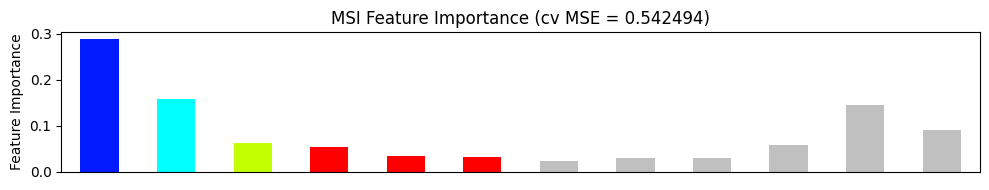

In [157]:
pipe_msi = exp_RFR_msi[2]
pd.Series(
    pipe_msi.regressor_.named_steps['regressor'].feature_importances_,
    index = wavelengths_msi).\
        plot(kind='bar',
             figsize=(10,2),
             color=[wavelength_to_rgb(w) for w in wavelengths_msi])
plt.xticks([])  # brak etykiet, bo mamy kolor
plt.ylabel("Feature Importance")
plt.title('MSI Feature Importance (cv MSE = %f)' % float(exp_mse_msi.loc['MEAN_MSE','MSE']))
plt.tight_layout()
plt.show()

In [ ]:
# SG deriv=1 usuwa importnace z wody
# SG deriv=2 znów o przywraca...



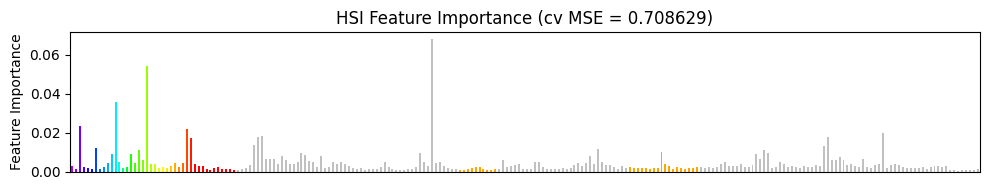

In [170]:
pipe_hsi = exp_RFR_hsi[2]

colors = []
water_color = 'orange'

klaster_1 = range(0, 98)
klaster_2 = range(108, 141)
klaster_3 = range(159, 230)
good_indices = list(klaster_1) + list(klaster_2) + list(klaster_3)

for i, w in enumerate(wavelengths_hsi):
    if i in good_indices:
        # Jeśli fala jest w klastrze, używamy Twojej funkcji koloru
        colors.append(wavelength_to_rgb(w))
    else:
        # Jeśli fala jest w "dziurze" między klastrami, kolorujemy na szarobłękitny
        colors.append(water_color)



pd.Series(
    pipe_hsi.regressor_.named_steps['regressor'].feature_importances_,
    index = wavelengths_hsi).\
        plot(kind='bar',
             figsize=(10,2),
             color=colors)
plt.xticks([])  # brak etykiet, bo mamy kolor
plt.ylabel("Feature Importance")
plt.title(f'HSI Feature Importance (cv MSE = %f)' % float(exp_mse_hsi.loc['MEAN_MSE','MSE']))
plt.tight_layout()
plt.show()

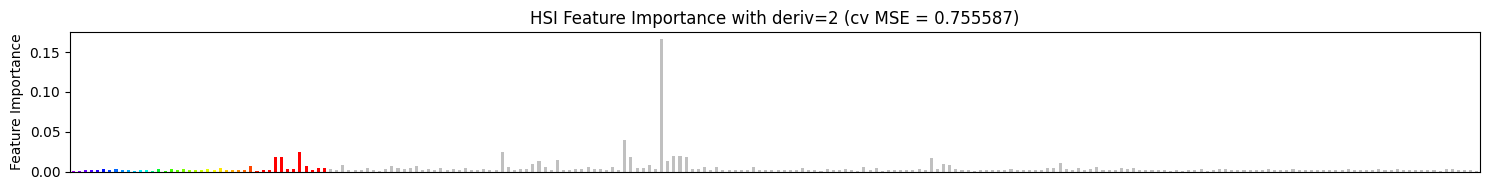

In [121]:
reg = pipe_hsi.regressor_.named_steps['regressor']
deriv = pipe_hsi.regressor_.named_steps['derivative'].deriv
pd.Series(
    reg.feature_importances_,
    index = [f"SG_{wl}_deriv:{deriv}" for wl in wavelengths_hsi]).\
        plot(kind='bar',
             figsize=(15,2),
             color=[wavelength_to_rgb(w) for w in wavelengths_hsi]
             )
plt.xticks([])  # brak etykiet, bo mamy kolor
plt.ylabel("Feature Importance")
plt.title(f'HSI Feature Importance with deriv={deriv} (cv MSE = %f)' % float(exp_mse_hsi.loc['MEAN_MSE','MSE']))
plt.tight_layout()
plt.show()

In [16]:
class SafeSNVTransformer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        X = np.array(X)
        mean = np.mean(X, axis=1, keepdims=True)
        std = np.std(X, axis=1, keepdims=True)
        std[std == 0] = 1e-98
        return (X - mean) / std
    
def spectral_binning(X, bin_size=10):
    # X shape (samples, 230)
    n_bins = X.shape[1] // bin_size
    X_binned = np.array([X[:, i*bin_size:(i+1)*bin_size].mean(axis=1) for i in range(n_bins)]).T
    return X_binned

def to_absorbance(X):
    return np.log10(1.0/ (X+1e-6))

class PLSFeatureExtractor(BaseEstimator, TransformerMixin):
    def __init__(self, n_components=5):
        self.n_components = n_components
        self.pls = PLSRegression(n_components=self.n_components)
    
    def fit(self, X, y=None):
        if y is None:
            raise ValueError("PLSRegression wymaga podania 'y' do treningu!")
        self.pls.fit(X, y)
        return self
    
    def transform(self, X):
        x_scores = self.pls.transform(X)
        if isinstance(x_scores, tuple):
            x_scores, _ = x_scores
        return x_scores

class BandFilterSNR(BaseEstimator, TransformerMixin):
    def __init__(self, threshold=0.5):
        self.threshold = threshold
        self.keep_idx = None

    def fit(self, X, y=None):
        snr = np.abs(np.mean(X, axis=0)) / np.std(X, axis=0)
        self.keep_idx = np.where(snr > self.threshold)[0]
        return self

    def transform(self, X):
        return X[:, self.keep_idx]

In [122]:
rfParams = {'n_jobs': 4,
        'oob_score':True, 
        'max_depth': 10,
        'n_estimators': 500,
        'min_samples_leaf': 4}
gbParams = {
    'n_estimators':95, 'learning_rate':.04, 
}

rfr = RandomForestRegressor(**rfParams)
rpl = PLSRegression(n_components=12)
gbr = MultiOutputRegressor(GradientBoostingRegressor(**gbParams))

sg21 = FunctionTransformer(lambda x: savgol_filter(x, window_length=11, polyorder=2, deriv=1))
sg31 = FunctionTransformer(lambda x: savgol_filter(x, window_length=11, polyorder=3, deriv=1), )
sg20 = FunctionTransformer(lambda x: savgol_filter(x, window_length=11, polyorder=2, deriv=0))
sg30 = FunctionTransformer(lambda x: savgol_filter(x, window_length=11, polyorder=3, deriv=0))
snr = BandFilterSNR(threshold=1.3)
snv = SafeSNVTransformer()
binn = FunctionTransformer(spectral_binning, kw_args={'bin_size': 2})

abs = FunctionTransformer(to_absorbance)
extrPLS = PLSFeatureExtractor(n_components=12)

cubist = MultiOutputRegressor(Cubist(
    n_rules=15,
    n_committees=6,
    unbiased=True,
))

snr+abs+sg21+cubist15 _____ {'hsi'}
X_train shape: (1876, 230)
Y_train shape: (1876, 6)


/home/katarzyna/cv_env/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but Cubist was fitted with feature names
  warnings.warn(
/home/katarzyna/cv_env/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but Cubist was fitted with feature names
  warnings.warn(
/home/katarzyna/cv_env/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but Cubist was fitted with feature names
  warnings.warn(
/home/katarzyna/cv_env/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but Cubist was fitted with feature names
  warnings.warn(
/home/katarzyna/cv_env/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but Cubist was fitted with feature names
  warnings.warn(
/home/katarzyna/cv_env/lib/pyt

snr+abs+sg21+pca+rf _____ {'msi', 'hsi'}
X_train shape: (1876, 12)
Y_train shape: (1876, 6)
X_train shape: (1876, 230)
Y_train shape: (1876, 6)
snr+abs+sg21+extrPLS+rf _____ {'hsi'}
X_train shape: (1876, 230)
Y_train shape: (1876, 6)
snr+abs+sg31+rf _____ {'msi', 'hsi'}
X_train shape: (1876, 12)
Y_train shape: (1876, 6)
X_train shape: (1876, 230)
Y_train shape: (1876, 6)
snr+sg30+pca+rf _____ {'msi', 'hsi'}
X_train shape: (1876, 12)
Y_train shape: (1876, 6)
X_train shape: (1876, 230)
Y_train shape: (1876, 6)
snr+sg31+pca+rf _____ {'msi', 'hsi'}
X_train shape: (1876, 12)
Y_train shape: (1876, 6)
X_train shape: (1876, 230)
Y_train shape: (1876, 6)
snr+snv+sg21+gb _____ {'msi', 'hsi'}
X_train shape: (1876, 12)
Y_train shape: (1876, 6)
X_train shape: (1876, 230)
Y_train shape: (1876, 6)
snr+snv+sg21+extrPLS+gb _____ {'hsi'}
X_train shape: (1876, 230)
Y_train shape: (1876, 6)
snv+snr+sg21+extrPLS+rf _____ {'hsi'}
X_train shape: (1876, 230)
Y_train shape: (1876, 6)
bin+snv+sg21+extrPLS+rf __

/tmp/ipykernel_96444/849590458.py:33: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('tab20c', 10)


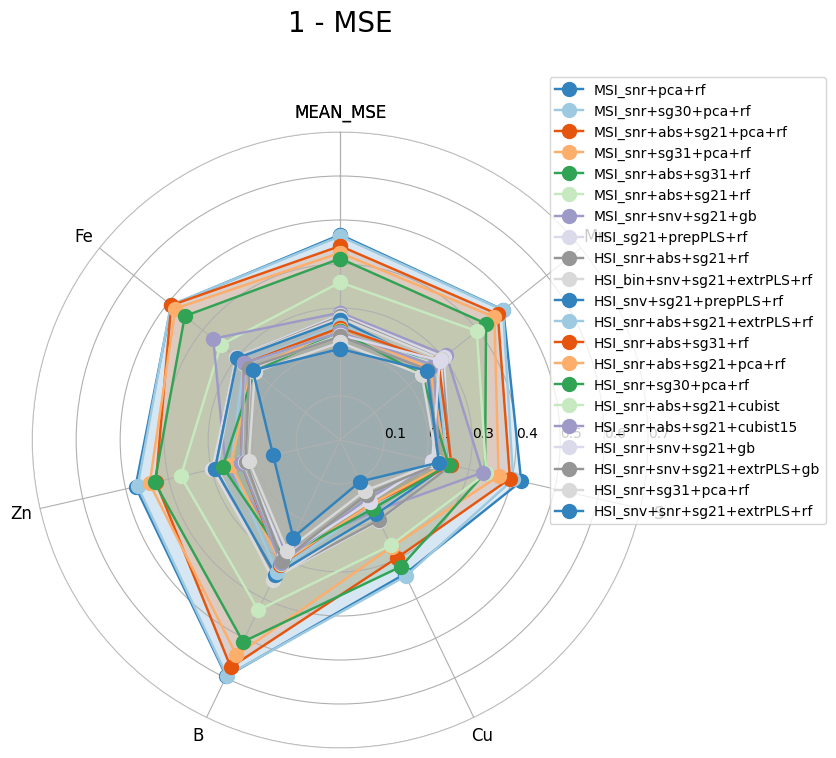

In [123]:
pipeline_0 = Pipeline([
     ('snr', snr), ('pca', PCA()), ("rf", rfr),
]), {'msi'}
pipeline_1 = Pipeline([
     ('snv', snv), ('snr', snr), ('pca', PCA()), ("rf", rfr),
]), {'msi'}
pipeline_cubist_0 = Pipeline([
    ('snr', snr),
    ('abs', abs),
    ('sg21', sg21),
    ('cubist15', cubist),
]), {'hsi'}
# pipeline_1 = Pipeline([
#     ('snr', snr), ('sg20', sg20), ("pls", rpl),
# ]), {'hsi'}
# pipeline_2 = Pipeline([
#     ('snr', snr), ('abs', abs), ('sg21', sg21), ("pls", rpl),
# ]), {'hsi'}
pipeline_3 = Pipeline([
    ('snr', snr), ('abs', abs), ('sg21', sg21), ("rf", rfr),
]), {'hsi', 'msi'}
pipeline_4 = Pipeline([
    ('snr', snr), ('abs', abs), ('sg21', sg20), ('pca', PCA()), ("rf", rfr),
]), {'hsi', 'msi'}
pipeline_5 = Pipeline([
    ('snr', snr), ('abs', abs), ('sg21', sg21), ('pca', PCA()), ("rf", rfr),
]), {'hsi', 'msi'}
pipeline_6 = Pipeline([
    ('snr', snr), ('abs', abs), ('sg21', sg21), ('extrPLS', extrPLS), ("rf", rfr),
]), {'hsi'}
pipeline_7 = Pipeline([
    ('snr', snr), ('abs', abs), ('sg31', sg31), ("rf", rfr),
]), {'hsi', 'msi'}
pipeline_8 = Pipeline([
    ('snr', snr), ('sg30', sg30), ('pca', PCA()), ("rf", rfr),
]), {'hsi', 'msi'}
pipeline_9 = Pipeline([
    ('snr', snr), ('sg31', sg31), ('pca', PCA()), ("rf", rfr),
]), {'hsi', 'msi'}
pipeline_10 = Pipeline([
    ("snr", snr), ("snv", snv), ('sg21', sg21), ("gb", gbr),
]), {'hsi', 'msi'}
pipeline_11 = Pipeline([
    ("snr", snr), ("snv", snv), ('sg21', sg21), ('extrPLS', extrPLS), ("gb", gbr),
]), {'hsi'}
pipeline_12 = Pipeline([
    ("snv", snv), ("snr", snr), ('sg21', sg21), ('extrPLS', extrPLS), ("rf", rfr),
]), {'hsi'}
pipeline_13 = Pipeline([
    ('snr', snr), ('abs', abs), ('sg21', sg21), ('extrPLS', extrPLS), ("rf", rfr),
]), {'hsi'}
pipeline_14 = Pipeline([
    ("bin", binn), ("snv", snv), ('sg21', sg21), ('extrPLS', extrPLS), ("rf", rfr),
]), {'hsi'}

total_bands = 230
klaster_1 = list(range(7, 98))    # VNIR
klaster_2 = list(range(108, 141))  # SWIR-1
klaster_3 = list(range(159, 223))  # SWIR-2
preprocessor_pls = ColumnTransformer([
    ('vnir_pls', PLSFeatureExtractor(n_components=8), klaster_1),
    ('swir1_pls', PLSFeatureExtractor(n_components=3), klaster_2),
    ('swir2_pls', PLSFeatureExtractor(n_components=5), klaster_3)
], remainder='drop')
pipeline_15 = Pipeline([
    # ('binning', binn), 
    ('sg21', sg21), ('prepPLS', preprocessor_pls), ('rf', rfr),
]), {'hsi'}
pipeline_15b = Pipeline([
    # ('binning', binn), 
    ('snv', snv), ('sg21', sg21), ('prepPLS', preprocessor_pls), ('rf', rfr),
]), {'hsi'}

# EXPERIMENT_RESULTS = {}
for pip, dataset_names in [
    pipeline_cubist_0,
    pipeline_0,
    # pipeline_1, pipeline_2,  # wywalić wszystkie pipeliny zawierające PLSRegressor na końcu.
      pipeline_3,pipeline_4, pipeline_5,
    pipeline_6, pipeline_7, pipeline_8, pipeline_9, pipeline_10,
    pipeline_11, pipeline_12, pipeline_13, pipeline_14, pipeline_15,    
    pipeline_15b,
]:
    name = '+'.join([ k for k,_ in pip.named_steps.items() ])
    if name in EXPERIMENT_RESULTS:
        continue
    if len({'hsi', 'msi'}.intersection(dataset_names))<1:
        pass
    print(name, '_____', dataset_names)
    temp_res = {}
    pipeline = TransformedTargetRegressor(regressor=pip, transformer=StandardScaler())
    if 'msi' in dataset_names:
        X_train_all, y_train_all, wavelengths_msi, y_names = load_data('msi')
        msi_res = run_experiment(
            pipeline,
            X_train_all, y_train_all,
            n_splits=3)
        temp_res['MSI'] = msi_res[0].rename(index=dict(zip(range(len(y_names)), y_names)))
        
    if 'hsi' in dataset_names:
        X_train_all, y_train_all, wavelengths_hsi, y_names = load_data('hsi')
        hsi_res = run_experiment(
            pipeline, X_train_all, y_train_all, n_splits=3)
        temp_res['HSI'] = hsi_res[0].rename(index=dict(zip(range(len(y_names)), y_names)))

    EXPERIMENT_RESULTS[name]=pd.concat(temp_res.values(), axis=0, keys=temp_res.keys())
res = plot_experiment_results(EXPERIMENT_RESULTS)

/tmp/ipykernel_96444/849590458.py:33: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('tab20c', 10)


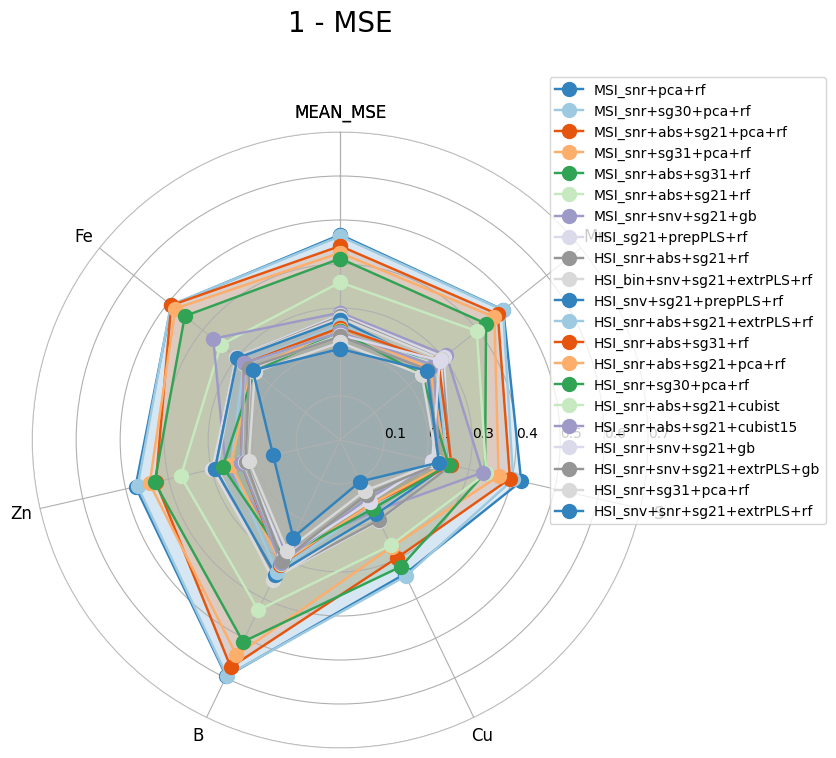

In [124]:
res = plot_experiment_results(EXPERIMENT_RESULTS)

/tmp/ipykernel_96444/849590458.py:33: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('tab20c', 10)


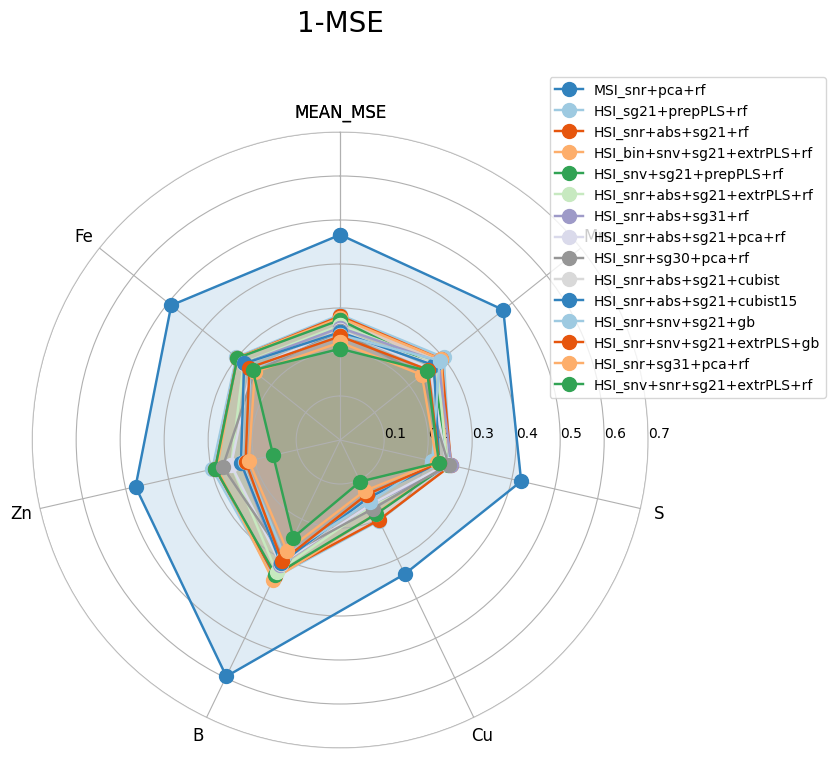

In [125]:
plot_radar_chart(res[res.index.str.contains('HSI|MSI_snr\+pca', regex=True)], '1-MSE')

/tmp/ipykernel_96444/849590458.py:33: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('tab20c', 10)


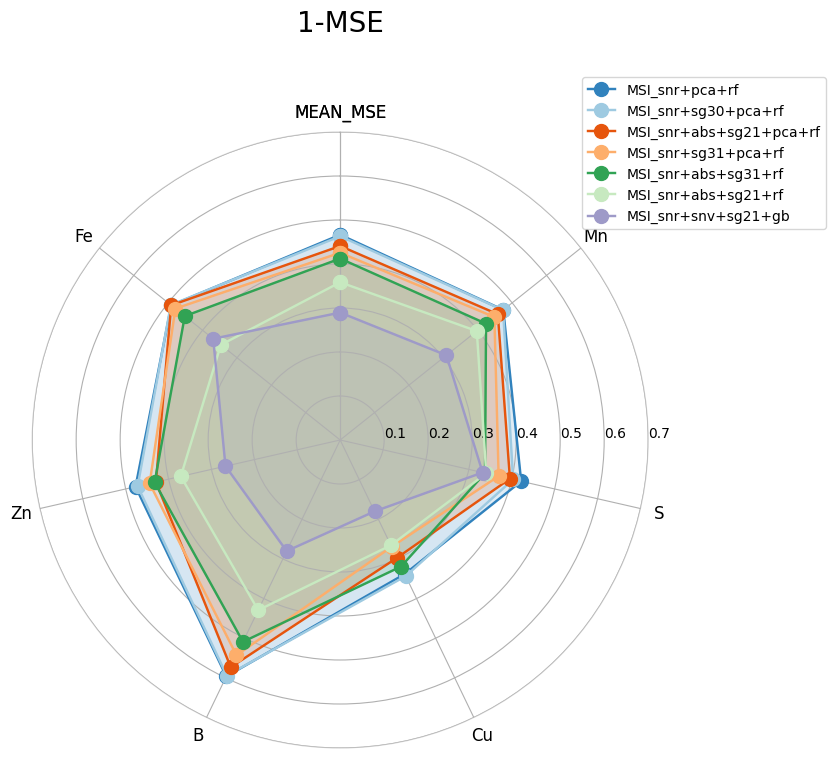

In [126]:
plot_radar_chart(res[res.index.str.contains('MSI')], '1-MSE')

In [110]:
print(res.sort_values('MEAN_MSE').to_markdown())

|                     |       Fe |       Zn |        B |       Cu |        S |       Mn |   MEAN_MSE |
|:--------------------|---------:|---------:|---------:|---------:|---------:|---------:|-----------:|
| MSI_snr+pca+rf      | 0.508979 | 0.522989 | 0.403656 | 0.661824 | 0.57804  | 0.525828 |   0.533553 |
| MSI_snr+abs+sg21+rf | 0.653177 | 0.628482 | 0.570646 | 0.734408 | 0.659494 | 0.602886 |   0.641515 |
| HSI_snr+abs+sg21+rf | 0.700772 | 0.708662 | 0.657321 | 0.797975 | 0.74121  | 0.705719 |   0.71861  |
